### **Inspiration**: Diamant M, Baruch S, Kassem E, Muhsen K, Samet D, Leshno M, Obolski U. A game theoretic approach reveals that discretizing clinical information can reduce antibiotic misuse. Nat Commun. 2021 Feb 19;12(1):1148. doi: 10.1038/s41467-021-21088-5. PMID: 33608511; PMCID: PMC7895914.

### **Imports**

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.integrate import trapezoid
from typing import Tuple, Optional

### **Settings**

In [19]:
# Set global font to support Polish characters
plt.rcParams['font.family'] = 'DejaVu Sans'

### **Figure 2**

In [20]:
def calculate_E_p(pdf: np.ndarray, p_values: np.ndarray) -> float:
    """
    Calculates the overall expected value E[p] for a given PDF.

    E[p] = integral(p * f(p) dp) from 0 to 1.

    Args:
        pdf (np.ndarray): The probability density function values f(p).
        p_values (np.ndarray): The corresponding p values (from 0 to 1).

    Returns:
        float: The expected value E[p].
    """
    # Use trapezoidal rule for numerical integration
    return trapezoid(p_values * pdf, p_values)

In [21]:
def calculate_conditional_expectations(pdf: np.ndarray, 
                                     p_values: np.ndarray, 
                                     T: float) -> Tuple[float, float]:
    """
    Calculates the conditional expectations p_L and p_H for a given 
    threshold T.

    p_L = E[p | p < T] (Expected value for the "Low" group)
    p_H = E[p | p >= T] (Expected value for the "High" group)

    Args:
        pdf (np.ndarray): The probability density function values f(p).
        p_values (np.ndarray): The corresponding p values (from 0 to 1).
        T (float): The discretization threshold.

    Returns:
        Tuple[float, float]: A tuple containing (p_L, p_H).
    """
    # Find the index closest to the threshold T
    idx = np.searchsorted(p_values, T)

    # Split into "Low" (p < T) and "High" (p >= T) groups
    p_low, pdf_low = p_values[:idx], pdf[:idx]
    p_high, pdf_high = p_values[idx:], pdf[idx:]

    # Calculate P(L) and P(H) (the total probability mass for each group)
    P_L = trapezoid(pdf_low, p_low)
    P_H = trapezoid(pdf_high, p_high)

    # Calculate the unnormalized expectations
    E_L = trapezoid(p_low * pdf_low, p_low)
    E_H = trapezoid(p_high * pdf_high, p_high)

    # Calculate the conditional expectations p_L and p_H
    # Handle potential division by zero if P_L or P_H are (close to) 0
    p_L = E_L / P_L if P_L > 1e-9 else 0
    p_H = E_H / P_H if P_H > 1e-9 else 0

    return p_L, p_H

In [22]:
def find_first_crossing_T0(p_H_minus_p_L: np.ndarray, 
                           E_p: float, 
                           T_values: np.ndarray) -> Optional[float]:
    """
    Finds the first (minimal) threshold T0 where the stability condition
    p_H - p_L >= E_p is met.

    Args:
        p_H_minus_p_L (np.ndarray): Array of (p_H - p_L) values for each T.
        E_p (float): The overall expected value E[p].
        T_values (np.ndarray): The array of thresholds T that were tested.

    Returns:
        Optional[float]: The value of T0 if it exists, otherwise None.
    """
    # Find all indices where the red curve is above or on the black line
    crossing_indices = np.where(p_H_minus_p_L >= E_p)[0]
    
    if len(crossing_indices) > 0:
        # Return the first T value that satisfies the condition
        return T_values[crossing_indices[0]]
    
    # If the curve never crosses, return None
    return None

#### 1. Define the domain of p

In [23]:
# We use a small epsilon (1e-5) to avoid the p=0 and p=1 singularities
# of the U-shaped beta(0.5, 0.5) distribution.
p_values = np.linspace(1e-4, 1 - 1e-4, 1000)

#### 2. Define parameters for the 4 Beta distributions (a, b)

In [24]:
dist_params = [
    {'a': 0.5, 'b': 0.5, 'title': '(a) Rozkład U-kształtny'},
    {'a': 1, 'b': 1, 'title': '(b) Rozkład jednostajny'},
    {'a': 1.5, 'b': 5, 'title': '(c) Rozkład skośny'},
    {'a': 5, 'b': 5, 'title': '(d) Rozkład dzwonowy'}
]

#### 3. Create the plot grid and loop through the 4 distributions

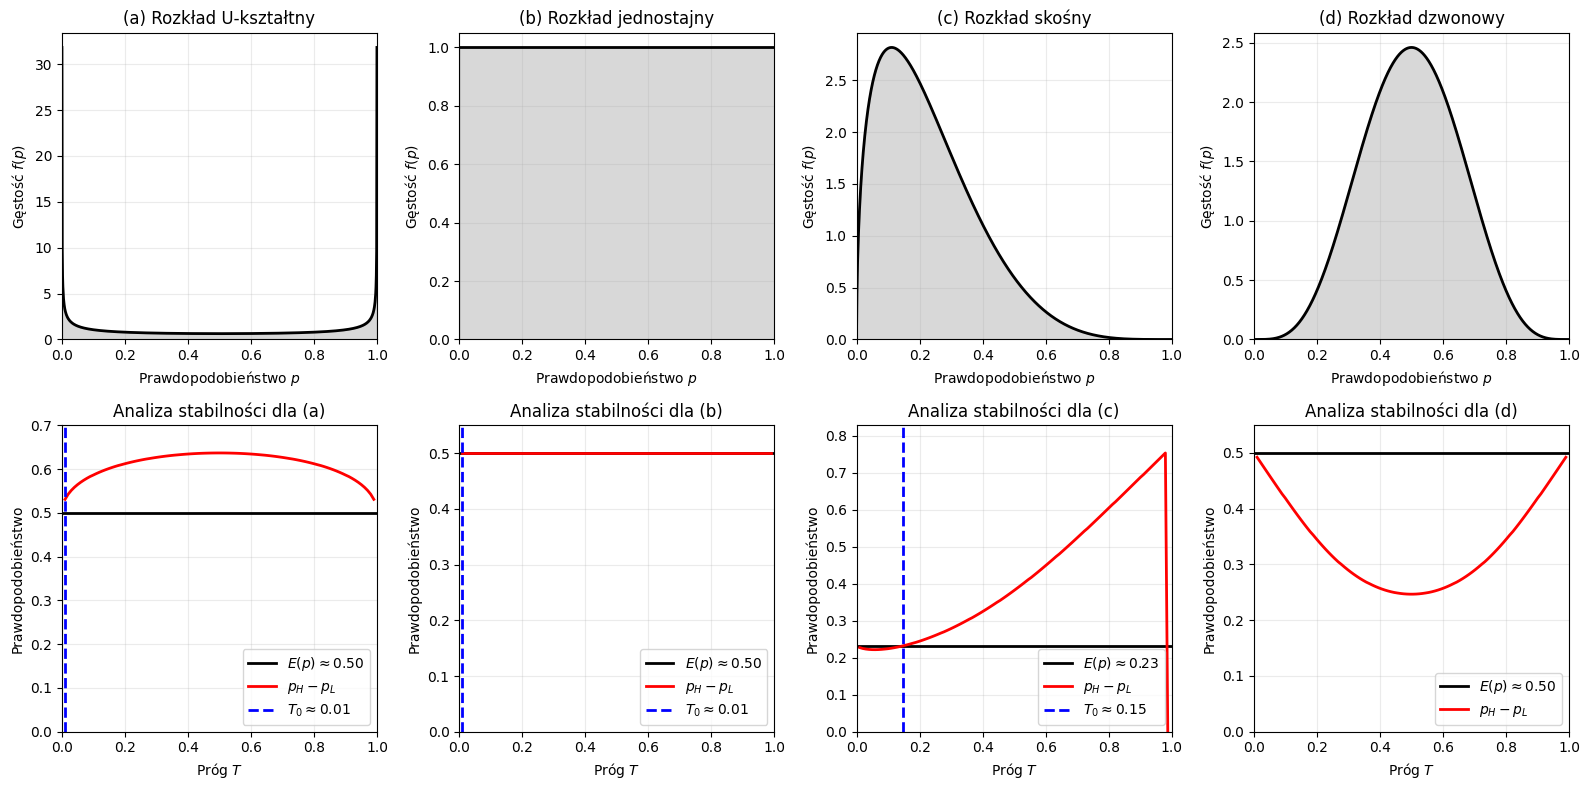

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, params in enumerate(dist_params):
    a, b = params['a'], params['b']
    dist = beta_dist(a, b)
    pdf = dist.pdf(p_values)
    
    # --- PDF plot (top row) ---
    ax_pdf = axes[0, i]
    ax_pdf.plot(p_values, pdf, 'k-', lw=2)
    ax_pdf.fill_between(p_values, pdf, color='gray', alpha=0.3)
    ax_pdf.set_title(params['title'])
    ax_pdf.set_xlabel('Prawdopodobieństwo $p$')
    ax_pdf.set_ylabel('Gęstość $f(p)$')
    ax_pdf.set_xlim(0, 1) # Still plot from 0 to 1
    ax_pdf.set_ylim(bottom=0)
    ax_pdf.grid(alpha=0.25)

    # --- Stability analysis plot (bottom row) ---
    ax_stability = axes[1, i]
    
    # Calculate the constant E[p]
    E_p_val = calculate_E_p(pdf, p_values)
    
    # Test different thresholds T
    T_values = np.linspace(0.01, 0.99, 100)
    p_H_minus_p_L = []

    for T in T_values:
        p_L, p_H = calculate_conditional_expectations(pdf, p_values, T)
        p_H_minus_p_L.append(p_H - p_L)
    
    p_H_minus_p_L = np.array(p_H_minus_p_L)

    # Plot E[p] (black line)
    ax_stability.axhline(E_p_val, color='black', linestyle='-', lw=2,
                         label=f'$E(p) \\approx {E_p_val:.2f}$')
    
    # Plot p_H - p_L (red curve)
    ax_stability.plot(T_values, p_H_minus_p_L, color='red', lw=2, label='$p_H - p_L$')

    # Find and draw T0 (minimal stability threshold)
    T0 = find_first_crossing_T0(p_H_minus_p_L, E_p_val, T_values)
    
    if T0 is not None:
        ax_stability.axvline(T0, color='blue', linestyle='--', lw=2, label=f'$T_0 \\approx {T0:.2f}$')
        
    # Calculate the upper limit for the y-axis with a 10% margin
    # To prevent the plot from clipping
    y_max_data = max(np.max(p_H_minus_p_L), E_p_val)
    y_top_limit = y_max_data * 1.1

    # Set axis labels and legend
    ax_stability.set_title(f'Analiza stabilności dla {params["title"][0:3]}')
    ax_stability.set_xlabel('Próg $T$')
    ax_stability.set_ylabel('Prawdopodobieństwo')
    ax_stability.set_xlim(0, 1)
    # Apply the new y-limits (bottom and top)
    ax_stability.set_ylim(bottom=0, top=y_top_limit) 
    ax_stability.legend(loc='lower right')
    ax_stability.grid(alpha=0.25)

plt.tight_layout()
plt.show()